In [1]:
import numpy as np
import xarray as xr

In [2]:
import sys
print(sys.path)
sys.path.append("/Users/dashadower/git_repos/stanify")

['/Users/dashadower/git_repos/stanify/vignette', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/dashadower/git_repos/stanify/venv/lib/python3.10/site-packages']


In [3]:
from stanify.builders.vensim2stan import Vensim2Stan

In [4]:
#vensim_model_path = "/Users/dashadower/git_repos/stanify/vensim_models/hier_prey_predator_wopnoise.mdl"
#vensim_model_path = "/Users/dashadower/git_repos/stanify/vensim_models/prey_predator_wopnoise.mdl"
vensim_model_path = "/Users/dashadower/git_repos/stanify/vensim_models/compare_vensim_stan.mdl"

In [5]:
v2s_code = """
//adj_frac1 ~ normal(0.5, 0.1);
ss_obs[timesteps] ~ normal(ss[timesteps], sigma);
//prey_obs[region, timesteps] ~ normal(prey[region, timesteps], sigma[region]);
sigma<lower=0.1> ~ lognormal(0, 1);
"""

In [6]:
max_time = 100

In [7]:
timesteps = np.arange(0, max_time, dtype=np.float32) + 1e-6

In [8]:
v2s = Vensim2Stan(v2s_code, vensim_model_path, "ss_obs", 0, timesteps, additional_data={"exog demand": xr.DataArray(2 * timesteps + 100, dims=["timesteps"], coords={"timesteps": timesteps.astype(np.integer)})})

/var/folders/dr/wk6zc3jn4s36h5dvr9w2tc_r0000gn/T/ipykernel_78166/1868211444.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  v2s = Vensim2Stan(v2s_code, vensim_model_path, "ss_obs", 0, timesteps, additional_data={"exog demand": xr.DataArray(2 * timesteps + 100, dims=["timesteps"], coords={"timesteps": timesteps.astype(np.integer)})})


In [9]:
v2s.v2s_code_handler.declared_variables

{'ss_obs': V2SVariableContext(name='ss_obs', subscripts=('timesteps',), sampled=True, lower=-inf, upper=inf),
 'sigma': V2SVariableContext(name='sigma', subscripts=(), sampled=True, lower=0.1, upper=inf)}

In [10]:
v2s.stan_model_context.transformed_data_variables

{'adj_frac1',
 'adj_frac2',
 'adj_frac3',
 'adj_frac5',
 'final_time',
 'initial_time',
 's2d_frac6',
 'safety_stock_coverage_frac7',
 'saveper',
 'ss2p_frac4',
 'time_step'}

In [11]:
v2s.vensim_model_context.variables

{'preparing': VensimVariableContext(name='preparing', subscripts=(), is_stock=False, is_static_data=False, is_lookup=False, is_vensim_datastructure=False),
 'adj_frac2': VensimVariableContext(name='adj_frac2', subscripts=(), is_stock=False, is_static_data=True, is_lookup=False, is_vensim_datastructure=False),
 'ds': VensimVariableContext(name='ds', subscripts=(), is_stock=False, is_static_data=False, is_lookup=False, is_vensim_datastructure=False),
 'pping': VensimVariableContext(name='pping', subscripts=(), is_stock=False, is_static_data=False, is_lookup=False, is_vensim_datastructure=False),
 'max_delivering': VensimVariableContext(name='max_delivering', subscripts=(), is_stock=False, is_static_data=False, is_lookup=False, is_vensim_datastructure=False),
 'table_for_order_fulfillment_ratio': VensimVariableContext(name='table_for_order_fulfillment_ratio', subscripts=(), is_stock=False, is_static_data=False, is_lookup=True, is_vensim_datastructure=False),
 'dping': VensimVariableContex

In [12]:
%%capture
sbc_idata = v2s.run_sbc(n_fits=100, n_draws=500, n_chains=4)

In [13]:
sbc_idata.prior.dims

Frozen({'prior_draw': 100, 'initial_state_dim_0': 4, 'ode_result_dim_0': 100, 'ode_result_dim_1': 4, 'timesteps': 100})

In [14]:
from stanify.calibrator.plots import plot_ecdf, plot_rank_hist

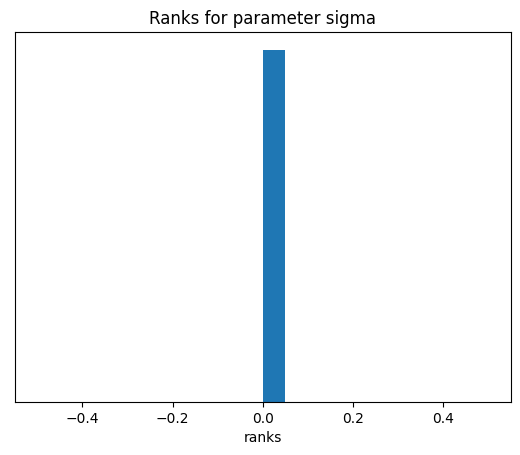

In [18]:
plot_rank_hist(sbc_idata, "sigma")

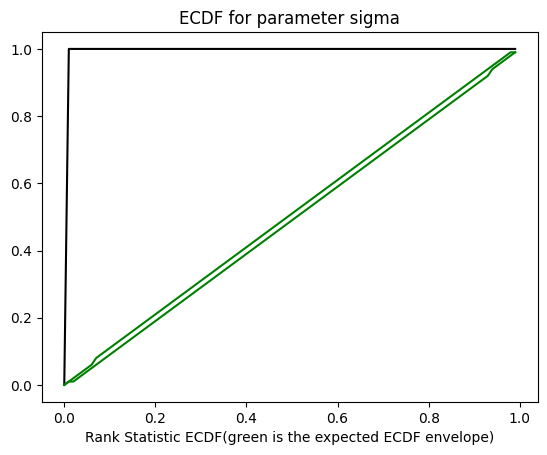

In [16]:
plot_ecdf(sbc_idata, "sigma")